### Maxwell A. Fine 14880725
### Assingment 2: Stastical Methods in Astrophysics

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.stats import pearsonr, spearmanr
from itertools import combinations # fancy nested for loop
from scipy.stats import norm
from scipy.stats import lognorm
import scipy.stats as sps
import scipy.integrate as spint
import scipy.integrate as spint
import scipy.interpolate as spinterp
from scipy.integrate import simps

# Set a seed for reproducibility
random_seed = 42

# Gaia correction term
gaia_corr = 0.029

### Initial Setup
First, load in the stars data as shown in Assignment 1, and create a dataframe containing only stars with Prob > 0.8, which you will use for the remainder of this assignment.

In [5]:
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()
stars = stars[stars['Prob']>0.8]
clcounts = stars.groupby(['Name']).size().reset_index(name='count') 

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


ColDefs(
    name = 'Name'; format = 'A20'; start = 1
    name = 'ID'; format = 'I4'; disp = 'I4'; start = 22
    name = 'GaiaDR3'; format = 'I19'; disp = 'I19'; start = 27
    name = 'inrt'; format = 'I1'; disp = 'I1'; start = 47
    name = 'Prob'; format = 'F10.8'; disp = 'F10.8'; start = 49
    name = 'RAdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 60
    name = 'e_RAdeg'; format = 'F10.8'; unit = 'arcsec'; disp = 'F10.8'; start = 73
    name = 'DEdeg'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 84
    name = 'e_DEdeg'; format = 'F10.8'; unit = 'arcsec'; disp = 'F10.8'; start = 97
    name = 'GLON'; format = 'F12.8'; unit = 'deg'; disp = 'F12.8'; start = 108
    name = 'GLAT'; format = 'E11.4'; unit = 'deg'; disp = 'E11.4'; start = 121
    name = 'pmRA'; format = 'E11.4'; unit = 'mas/yr'; disp = 'E11.4'; start = 133
    name = 'e_pmRA'; format = 'F10.8'; unit = 'mas/yr'; disp = 'F10.8'; start = 145
    name = 'pmDE'; format = 'E11.4'; unit = 'mas/yr'; d

### Task 1:
Use your stars dataframe to calculate the following 6 sample quantities per cluster: 
- the number of
stars in the cluster �∗; 
- the mean parallax, �$, of the stars in the cluster;
- the standard deviation �& of
the parallax of the stars in the cluster;
- the ‘size’ of the cluster �pos calculated using the standard
deviation in RA and Dec position of the stars1
;
- the mean proper motion of the cluster stars �̅;
- the standard deviation of the proper motion of the cluster stars �- (which can be calculated by adding in quadrature the RA and dec proper motion standard deviations, i.e. the same as for �pos). 

To help you do this in Pandas, you can adapt the code you used for Assignment 1:
clusters_hiprob = stars_hiprob.groupby(['Name']).size().reset_index(name='n_star')
clusters_sd_hiprob = stars_hiprob.groupby(['Name']).std(numeric_only=True).reset_index()
where the .std method calculates the sample standard deviations for all numerical quantities in the
stars data frame grouped according to cluster name, and a similar method exists for the sample
mean. Those can then be used to add the required columns to the dataframe with �∗.


Now, select only the clusters which satisfy �∗ > 200, �pos < 1∘
and for these clusters plot the 5
astrometric quantities only (i.e. excluding �∗) in a scatter-matrix plot, to compare each pair of
quantities and show their histograms. Comment on whether there are any clear correlations revealed
by the scatter plots.


### Idea:
* We can use the pandas 'groupby' function to grab all the stars from a cluster and perform our operation
* Make a new pd to hold our resulting data
* Modify last weeks plotting code (write a function this time!) for our corner plot
* Name of 6 parameters 
    - 'count' : # Number of stars in the cluster
    - 'Plx' : # Parallax of the star
    - 'RAdeg' : #  RA in deg
    - 'pmra' : # proper motion of the star

### Assumptions
- N/A for this problem 

In [6]:
my_stars_plx = stars[stars['Name'] == 'vdBergh_92']['Plx']
my_stars_plx

1291586    0.8721
1291588    0.8907
1291591    0.8960
1291594    0.8100
1291595    0.8281
            ...  
1291922    0.8562
1291923    0.8714
1291924    0.8419
1291925    0.9300
1291928    0.8469
Name: Plx, Length: 166, dtype: float64

In [71]:
# Cell to calculate cluster stastics 
# Group by 'Name' and calculate the required quantities
cluster_stats = stars.groupby('Name').agg(
    num_stars=('Name', 'count'),  # Number of stars 
    mean_parallax=('Plx', 'mean'),  # Mean parallax
    std_parallax=('Plx', 'std'),  # STD parallax
    mean_proper_motion=('pmRA', 'mean'),  # Mean proper motion
)

# Mean Proper motion
# Quadrature sum of RA and dec to calculate proper motion
mean_pmRA = stars.groupby('Name')['pmRA'].agg('mean')
mean_pmDEC = stars.groupby('Name')['pmDE'].agg('mean') # Ugh why is the data using 'DE' not 'DEC'??
mean_proper_motion = (mean_pmRA**2 + mean_pmDEC**2)**0.5
cluster_stats['mean_proper_motion'] = mean_proper_motion

# Size
# Quadrature sum of RA and dec to calculate 'Size'
std_radeg = stars.groupby('Name')['RAdeg'].agg('std')
std_decdeg = stars.groupby('Name')['DEdeg'].agg('std') # Ugh why is the data using 'DE' not 'DEC'??
size = (std_radeg**2 + std_decdeg**2)**0.5
cluster_stats['cluster_size'] = size

# STD proper motion
# Quadrature sum of RA and dec proper motion standard deviations
std_pm_ra = stars.groupby('Name')['pmRA'].agg('std')
std_pm_dec = stars.groupby('Name')['pmDE'].agg('std')
std_proper_motion = (std_pm_ra**2 + std_pm_dec**2)**0.5

# Add the calculated standard deviation of proper motion to the cluster_stats DataFrame
cluster_stats['std_proper_motion'] = std_proper_motion

# Filter only keeping num_stars > 200 & cluster_size < 1 degree
filtered_cluster_stats = cluster_stats[(cluster_stats['num_stars'] > 200) & (cluster_stats['cluster_size'] < 1)].reset_index()
filtered_cluster_stats


,Name,num_stars,mean_parallax,std_parallax,mean_proper_motion,cluster_size,std_proper_motion
0,BH_131,227,0.125637,0.046214,6.536827,0.221680,0.154404
1,BH_140,338,0.190195,0.043486,14.897046,0.127424,0.129645
2,BH_66,355,0.123089,0.044962,5.470541,0.180838,0.229493
3,Berkeley_36,217,0.217359,0.065872,1.967901,0.063243,0.099389
4,Berkeley_39,211,0.226982,0.038289,2.371439,0.045639,0.068647
...,...,...,...,...,...,...,...
193,UBC_461,231,0.298768,0.031775,4.096675,0.419239,0.109858
194,UBC_517,256,0.405671,0.022682,5.685520,0.716871,0.127498
195,UBC_600,390,0.171171,0.039550,1.191558,0.721515,0.134289
196,UFMG_2,212,0.377292,0.026794,5.382440,0.073233,0.102454


In [70]:
# define corner plot function
def corner_plot(labels, plotting_df, parameters):
    '''
    Generate a corner plot to visualize relationships between variables.

    Parameters:
    - labels (list): List of labels for each dimension/variable to be plotted.
    - plotting_df (DataFrame): Pandas DataFrame containing the data to be plotted.
    - parameters (list): List of parameter names corresponding to the columns in `plotting_df` to be plotted.

    Returns:
    None

    This function generates a corner plot with subplots showing histograms along the diagonal
    and scatter plots for the relationships between variables in the off-diagonal subplots.
    The plots are based on the specified labels and parameters.

    Note:
    - The function assumes that `plotting_df` is a pandas DataFrame.
    - It uses logarithmic scales for the axes in the scatter plots.
    - The diagonal plots show histograms of the corresponding variables.
    - The off-diagonal plots show scatter plots of the relationships between variables.
    '''
    ndims = len(labels)
    # Nested for loop for plotting
    fig, axes = plt.subplots(ndims, ndims, figsize=(12, 12))
    fig.subplots_adjust(wspace=0.5, hspace=0.4)

    for i in range(ndims):  # y dimension of the grid
        for j in range(ndims):  # x dimension of the grid
            axes[i, j].tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

            if i == j:
                axes[i, j].hist(np.log10(plotting_df[parameters[i]].values), bins=20, color='green', alpha=0.7)
            elif i > j:
                axes[i, j].scatter(np.log10(plotting_df[parameters[j]].values), np.log10(plotting_df[parameters[i]].values), color='green', alpha=0.3, linewidths=0.5)
                # Set double log scale for both x-axis and y-axis
                #axes[i, j].set_xscale('log')
            # axes[i, j].set_yscale('log')
            else:
                axes[i, j].axis('off')

            if j == 0:
                if i == j:
                    axes[i, j].set_ylabel('Counts', fontsize=12)
                else:
                    axes[i, j].set_ylabel(labels[i], fontsize=12)

            if i == ndims - 1:
                axes[i, j].set_xlabel(labels[j], fontsize=12)

    plt.suptitle('Filtered Cluster Statstics\n N = ' + str(len(plotting_df[labels[i]].values)), size=20, y=0.9)
    plt.show()

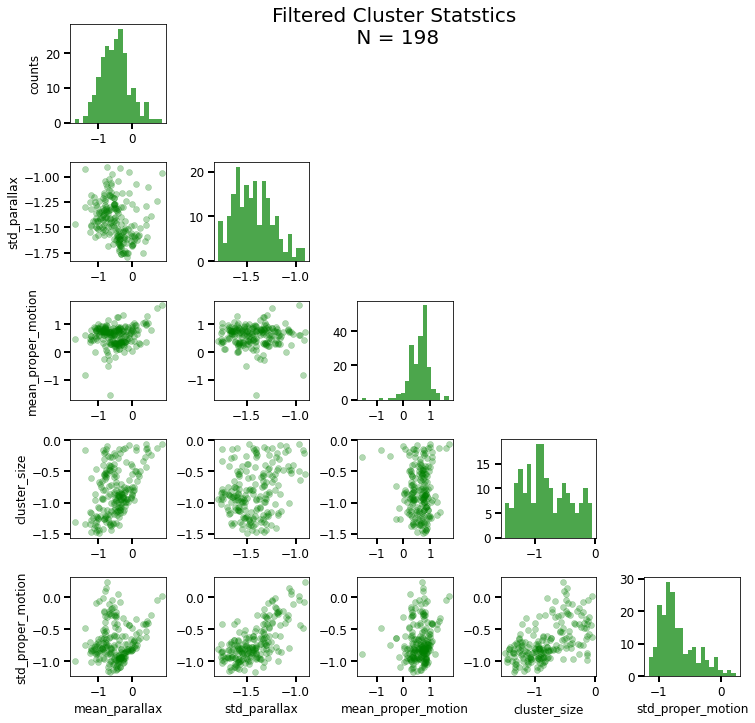

In [32]:
plotting_df = filtered_cluster_stats
labels = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']
parameters = labels

corner_plot(labels, plotting_df, parameters)

### 1 Comments:

Judging by the scatter matrix plot (aka the corner plot), there are some very clear correlations of different parameters. They do not appear as independent Guassians. However the indiivudal parameters do appear as  Gaussian distrubtions. 

### Add more comments



### Task 2 Correlation tests:

### A. 
Now search for correlations by calculating the Pearson and Spearman correlation coefficients
and p-values for each of the combinations shown in the scatter-matrix plots. Comment on
whether the tests are appropriate given the observed distributions of the measured
quantities.
### B. 
You can improve the situation by performing the tests on log-transformed data (i.e. on the
logarithm of the quantities instead of the original values). Why should this make the tests
more reliable? Finally, comment on your results and their implications.


In [63]:
def pearson_and_spearman_corr(dataframe, parameters, log=False):
    '''
    Calculate Pearson and Spearman correlation coefficients and p-values for pairs of parameters in a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame containing the data.
    - parameters (list): List of parameter labels for which correlations will be calculated.
    - log (bool, optional): If True, the correlation is calculated on the logarithm of the data. Default is False.

    Returns:
    pd.DataFrame: A DataFrame containing the results with columns:
    - 'Comparison': String indicating the pair of parameters being compared.
    - 'Pearson Coefficient': Pearson correlation coefficient for the pair.
    - 'Pearson P-Value': P-value corresponding to the Pearson correlation.
    - 'Spearman Coefficient': Spearman correlation coefficient for the pair.
    - 'Spearman P-Value': P-value corresponding to the Spearman correlation.
    '''

    # Create an empty DataFrame to store the results
    correlation_results_df = pd.DataFrame(columns=['Comparison', 'Pearson Coefficient',
                                               'Pearson P-Value', 'Spearman Coefficient', 'Spearman P-Value'])


    # Calculate correlation coefficients and p-values
    for label1, label2 in combinations(parameters, 2): # Fancy nested for loop


        if log == False:
            # Calculate Pearson correlation coefficient and p-value
            pearson_corr, pearson_p_value = pearsonr(dataframe[label1], dataframe[label2])

            # Calculate Spearman correlation coefficient and p-value
            spearman_corr, spearman_p_value = spearmanr(dataframe[label1], dataframe[label2])

        if log == True:
            # Calculate Pearson correlation coefficient and p-value
            pearson_corr, pearson_p_value = pearsonr(np.log10(dataframe[label1]), np.log10(dataframe[label2]))

            # Calculate Spearman correlation coefficient and p-value
            spearman_corr, spearman_p_value = spearmanr(np.log10(dataframe[label1]), np.log10(dataframe[label2]))

        # Place results in pd, this is similar to a dict
        comparison_key = f'{label1} vs {label2}'
        correlation_results_df = pd.concat([
            correlation_results_df,
            pd.DataFrame({
                'Comparison': [comparison_key],
                'Pearson Coefficient': [pearson_corr],
                'Pearson P-Value': [pearson_p_value],
                'Spearman Coefficient': [spearman_corr],
                'Spearman P-Value': [spearman_p_value]
            })
        ], ignore_index=True)

    return correlation_results_df


In [64]:
# 2A
parameters = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']
correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats, parameters=parameters, log=False)
log_correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats, parameters=parameters, log=True)
correlations

/tmp/ipykernel_9202/106759896.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([
/tmp/ipykernel_9202/106759896.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_parallax vs std_parallax,0.047611,5.053547e-01,-0.376186,4.712017e-08
1,mean_parallax vs mean_proper_motion,0.668548,5.222066e-27,0.051292,4.729721e-01
2,mean_parallax vs cluster_size,0.476555,1.275929e-12,0.373636,5.897056e-08
3,mean_parallax vs std_proper_motion,0.228468,1.206247e-03,0.025229,7.242273e-01
4,std_parallax vs mean_proper_motion,0.129134,6.980531e-02,-0.013398,8.513929e-01
5,std_parallax vs cluster_size,0.341305,8.621712e-07,0.208774,3.160198e-03
6,std_parallax vs std_proper_motion,0.713024,4.760937e-32,0.604036,4.484188e-21
7,mean_proper_motion vs cluster_size,0.236015,8.156744e-04,-0.005288,9.410603e-01
8,mean_proper_motion vs std_proper_motion,0.264974,1.615733e-04,0.153248,3.112366e-02
9,cluster_size vs std_proper_motion,0.403202,3.872148e-09,0.554065,2.508930e-17


In [65]:
# 2B
log_correlations

,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_parallax vs std_parallax,-0.252036,3.409650e-04,-0.376186,4.712017e-08
1,mean_parallax vs mean_proper_motion,0.196391,5.553836e-03,0.051292,4.729721e-01
2,mean_parallax vs cluster_size,0.428522,3.012242e-10,0.373636,5.897056e-08
3,mean_parallax vs std_proper_motion,0.111445,1.180250e-01,0.025229,7.242273e-01
4,std_parallax vs mean_proper_motion,-0.002964,9.669425e-01,-0.013398,8.513929e-01
5,std_parallax vs cluster_size,0.264515,1.660300e-04,0.208774,3.160198e-03
6,std_parallax vs std_proper_motion,0.673524,1.576212e-27,0.604036,4.484188e-21
7,mean_proper_motion vs cluster_size,-0.027338,7.022286e-01,-0.005288,9.410603e-01
8,mean_proper_motion vs std_proper_motion,0.169528,1.695536e-02,0.153248,3.112366e-02
9,cluster_size vs std_proper_motion,0.557149,1.535025e-17,0.554065,2.508930e-17


### 2 Comments:


### 3 Intro to Bayesian thinking:

Now randomly select a cluster from the sample used in Task 2. Using the parallaxes of the individual
stars in the cluster, use Bayes’ theorem to calculate the posterior pdf for the distance � (in kpc) to the
cluster, using the formula � = 1/� where � is the parallax in milliarcsec (mas). Gaia has a known
‘zero-point’ offset - a systematic error – in the parallax, so before you do your calculation you
should first add a correction of 0.029 mas to the parallax measurements. You should calculate the
posterior pdf for two different prior pdfs:

a. a uniform prior distrubution 

b. A more realistic pdf corresponding to constant volume density modified by an exponential
decrease with distance: p(d) ~ d^2 exp(-d/l), where L = 1kpc is a charastric length scale

You may assume that the corrected parallax measurements are normally distributed about the true
parallax, with standard deviation given by the errors on the parallax measurements. For each prior,
calculate the distance corresponding to the mode (maximum) of the posterior pdf, plot your posterior
pdf (on the same plot for both priors) and determine the 1-� confidence interval on the distance and
indicate the mode and interval on your pdf. Also on the same plot, compare the Bayesian posterior
pdfs with the pdf you obtain just by assuming the normal distribution with mean obtained by
inverting the mean parallax for the cluster, �$ (to obtain �) and standard deviation obtained by
propagating the standard error on �$, to obtain the standard deviation on �.
Finally, repeat the analysis above using just 10 stars from the cluster (you should pick a random subsample), to see the effect of smaller numbers.
Hint for fast numerical calculation: to output a pandas data column to a numpy array which you can
reshape as needed, use the .values method.

In [91]:
# lets make a function version 
def bayesian_analysis_distance(cluster_df, cluster_name, prior_type='uniform',
                               plot=True, print_results=True, color='red', 
                               label='label', linestyle='-'):
    
    """
    Perform Bayesian analysis to estimate the distance to a star cluster based on parallax measurements.

    Parameters:
    - cluster_df (pandas df): Data frame of all clusters, needs e_plx, plx, name cols
    - cluster_name (str): Name of the star cluster for labeling the plot and results.
    - prior_type (str, optional): Type of prior distribution. Options are 'uniform' (default) or 'exp'.
    - plot (bool, optional): If True, plot the posterior probability density function. Default is True.
    - print_results (bool, optional): If True, print the results including integral value, maximum likelihood
      position, and 1-sigma confidence interval. Default is True.
    - color (str, optional): Color of the plot line. If None, a default color will be used.
    - label (str, optional): Label for the plot legend. If None, no label will be added.
    - linestyle (str, optional): Line style of the plot. If None, a default style will be used.

    Returns:
    - dist_arr (array): Array of distance values used in the analysis.
    - posterior_pdf (array): Posterior probability density function for the distance.
    - max_likelihood_position (float): Maximum likelihood position of the distance.
    - int95 (array): 1-sigma confidence interval for the distance.

    Note:
    - The function uses a Bayesian approach with either a uniform or exponential prior to estimate the posterior
      probability density function for the distance to the star cluster.
    - The plot displays the posterior probability density function if `plot` is set to True.
    - Results including the integral value, maximum likelihood position, and 1-sigma confidence interval are printed
      if `print_results` is set to True.
    """

    plx = cluster_df[cluster_df['Name'] == cluster_name]['Plx'].values
    e_plx = cluster_df[cluster_df['Name'] == cluster_name]['e_Plx'].values
    

    my_stars_plx = plx + gaia_corr # Adding correction factor

    # Create a grid of 1000 values of lambda to calculate the posterior over:
    # we are going a bit under and a bit over the min and max values
    dist_arr = np.linspace(0.8 / np.max(my_stars_plx ), 1.2 / np.min(my_stars_plx ), int(1e3))

    # Set parameters for log-normal distribution
    x = my_stars_plx.reshape(len(my_stars_plx),1)
    scale = e_plx.reshape(len(x), 1)
    loc = 1/(dist_arr.reshape(1, len(dist_arr)))

    # Calculate Prior
    if prior_type == 'uniform':
        prior = 1 * np.ones(len(dist_arr))
        
    if prior_type == 'exp':
        prior = (dist_arr)**2 * np.exp(-dist_arr)

    # Calculate log-likelihood * prior for  distribution
    # this is the numerator in Baye's   formula
    loglikel_ln = np.sum(sps.norm.logpdf(x=x, scale=scale, loc=loc,), axis=0)+ np.log(prior)

    likel_ln = np.exp(loglikel_ln ) # convert back from log space

    # Calculate denominator for Baye's formula
    likel_ln_int = spint.simpson(likel_ln, dist_arr, axis=0)

    # Now we normalize and we have our posterior pdf 
    posterior_pdf = likel_ln  / likel_ln_int

    # Find Maximum Likelihood Position
    max_likelihood_position = dist_arr[np.argmax(posterior_pdf)]

    # Calculate 1-Sigma Confidence Interval
    # Calculate 95% confidence interval. The range must be 0.95, centred on 0.5 (the median)
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf,dist_arr,initial=0)
    posterior_ppf = spinterp.interp1d(posterior_cdf,dist_arr)
    int95 = posterior_ppf([0.025,0.975])


    # plotting
    if plot == True:
        
        plt.plot(dist_arr, posterior_pdf, color=color, label=label, linestyle=linestyle, alpha=0.5, linewidth=3)
        # Add vertical line for mode
        plt.axvline(max_likelihood_position, linestyle='-.', color='k', alpha=0.5, label='Mode:' + label, linewidth=3)

        # Add vertical lines for 1 sigma 
        plt.axvline(int95[0], linestyle=':', color=color, label='1-Sigma Confidence Interval', alpha=0.5, linewidth=3)
        plt.axvline(int95[1], linestyle=':', color=color, alpha=0.5, linewidth=3)
        # Legend and plotting garb
        plt.legend(fontsize=12)
        plt.xlabel(r'Distance (Kpc)', size=15)
        plt.ylabel(r'Posterior pdf (prob/Kpc)', size=15)
        plt.title(cluster_name + '\n N = ' + str(len(plx)),  size=15)

        # x lim
        plt.xlim (0.8 * int95[0], 1.2*int95[1])
       

    
    # Print results
    if print_results == True:
        print(label)
        # Calculate the integral using the trapezoidal rule
        integral_value = simps(posterior_pdf, dist_arr)
        print("Posterior pdf Integral value:", integral_value)
        print("Maximum Likelihood Position:", max_likelihood_position, ' Kpc')
        print("1-Sigma Confidence Interval:" ,int95, ' Kpc')
        print('\n')

    # Return 
    return dist_arr, posterior_pdf, max_likelihood_position, int95
    

   


Uniform Prior
Posterior pdf Integral value: 0.9999999999999999
Maximum Likelihood Position: 3.980931448422832  Kpc
1-Sigma Confidence Interval: [3.89365229 4.07395456]  Kpc


Exp Prior
Posterior pdf Integral value: 1.0
Maximum Likelihood Position: 3.980931448422832  Kpc
1-Sigma Confidence Interval: [3.89262246 4.07273042]  Kpc




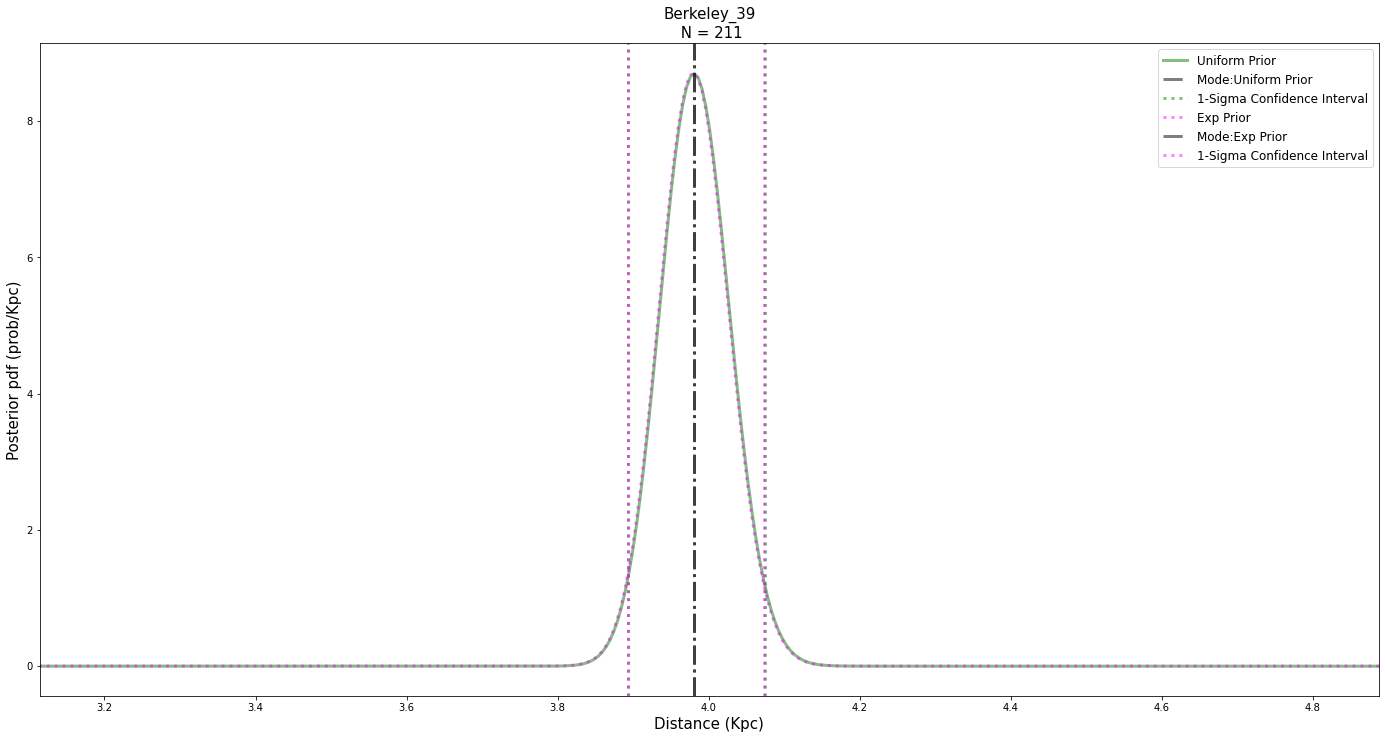

In [92]:
plt.figure(figsize=(24,12))
cluster_name = 'Berkeley_39'
    
color='Green'
label='Uniform Prior'
linestyle='-'
prior_type = 'uniform'
result= bayesian_analysis_distance(cluster_df=stars, cluster_name=cluster_name, prior_type='uniform',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)

color='magenta'
label='Exp Prior'
linestyle=':'
prior_type ='exp'
result= bayesian_analysis_distance(cluster_df=stars, cluster_name=cluster_name, prior_type='exp',
                                   plot=True, print_results=True, color=color, 
                                   label=label, linestyle=linestyle)



### Part 4:

Now repeat the Bayesian distance calculation for all clusters used in the correlation sample in Task 2,
using only the more realistic, constant density exponentially decreasing prior. You should obtain the
distance estimate for each cluster from the maximum posterior probability of �. Then, use your
distances to correct these 4 observed quantities to the values they would have at a fixed distance of 1
kpc: �& , �pos , �̅, �-. For these four corrected quantities, show the scatter-matrix plot and perform
Pearson and Spearman correlation tests. Comment on your results and how they differ compared to
what you obtained in Task 1 and 2 for the same quantities.


* labels = ['mean_parallax', 'std_parallax', 'mean_proper_motion', 'cluster_size', 'std_proper_motion']

- std_parallax
- cluster_size
- proper_motion
- std_proper_motion

In [16]:

# Run Bayesian distance calculation on all unique cluster names
unique_names = filtered_cluster_stats['Name']
distance_results_df = pd.DataFrame() # Initalize results df 
filtered_cluster_stats_corr = pd.DataFrame() # Initalize df for the corrections
for name in unique_names:
    dist_arr, posterior_pdf, max_likelihood_position, int95 = bayesian_analysis_distance(cluster_df=stars, cluster_name=name, prior_type='exp',
                                    plot=False, print_results=False, color=color, 
                                    label=label, linestyle=linestyle)

    # Create a temp df for the current iteration
    temp_df = pd.DataFrame({
            'Name': [name],
            'Max_Likelihood_Position_kpc': [max_likelihood_position],
            'lower_1sigma_kpc': int95[0], 
            'higher_1sigma_kpc': int95[1],
        })

    # Concatenate the temp df to the results_df
    distance_results_df = pd.concat([distance_results_df, temp_df], ignore_index=True)

    # Make corrections and save to output df
    correction_factor = max_likelihood_position

    # Temp corr df
    temp_df = pd.DataFrame({
        'Name': name,
        'mean_parallax':  filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['mean_parallax'] * correction_factor,
        'std_parallax': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['std_parallax']* correction_factor,
        'mean_proper_motion': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['mean_proper_motion'] * correction_factor,
        'cluster_size': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['cluster_size'] * correction_factor,
        'std_proper_motion': filtered_cluster_stats[filtered_cluster_stats['Name'] ==  name]['std_proper_motion'] * correction_factor,
    })

    # Concatenate the temp df to the stars_corr_df
    filtered_cluster_stats_corr = pd.concat([filtered_cluster_stats_corr, temp_df], ignore_index=True)

filtered_cluster_stats_corr




/tmp/ipykernel_9202/1607550491.py:66: RuntimeWarning: invalid value encountered in divide
  posterior_pdf = likel_ln  / likel_ln_int
/tmp/ipykernel_9202/1607550491.py:60: RuntimeWarning: overflow encountered in exp
  likel_ln = np.exp(loglikel_ln ) # convert back from log space
/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:416: RuntimeWarning: overflow encountered in multiply
  y[slice1] * (hsum * hsum / hprod) +
/tmp/ipykernel_9202/1607550491.py:58: RuntimeWarning: divide by zero encountered in log
  loglikel_ln = np.sum(sps.norm.logpdf(x=x, scale=scale, loc=loc,), axis=0)+ np.log(prior)
/tmp/ipykernel_9202/1607550491.py:54: RuntimeWarning: overflow encountered in exp
  prior = (dist_arr)**2 * np.exp(-dist_arr)
/tmp/ipykernel_9202/1607550491.py:54: RuntimeWarning: overflow encountered in multiply
  prior = (dist_arr)**2 * np.exp(-dist_arr)
/home/afinemax/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:415: RuntimeWarning: over

,Name,mean_parallax,std_parallax,mean_proper_motion,cluster_size,std_proper_motion
0,BH_131,0.804957,0.296090,41.881394,1.420300,0.989267
1,BH_140,0.882039,0.201671,69.085773,0.590933,0.601236
2,BH_66,0.809288,0.295620,35.967888,1.188978,1.508880
3,Berkeley_36,0.885046,0.268218,8.012931,0.257512,0.404692
4,Berkeley_39,0.903598,0.152425,9.440538,0.181686,0.273281
...,...,...,...,...,...,...
193,UBC_461,0.895641,0.095255,12.280952,1.256789,0.329331
194,UBC_517,0.928688,0.051926,13.015642,1.641106,0.291877
195,UBC_600,0.824658,0.190544,5.740606,3.476066,0.646966
196,UFMG_2,0.939639,0.066731,13.404857,0.182385,0.255159


/tmp/ipykernel_9202/4127619707.py:33: RuntimeWarning: invalid value encountered in log10
  axes[i, j].hist(np.log10(plotting_df[parameters[i]].values), bins=20, color='green', alpha=0.7)
/tmp/ipykernel_9202/4127619707.py:35: RuntimeWarning: invalid value encountered in log10
  axes[i, j].scatter(np.log10(plotting_df[parameters[j]].values), np.log10(plotting_df[parameters[i]].values), color='green', alpha=0.3, linewidths=0.5)


KeyError: 'Log(STD Parallax)'

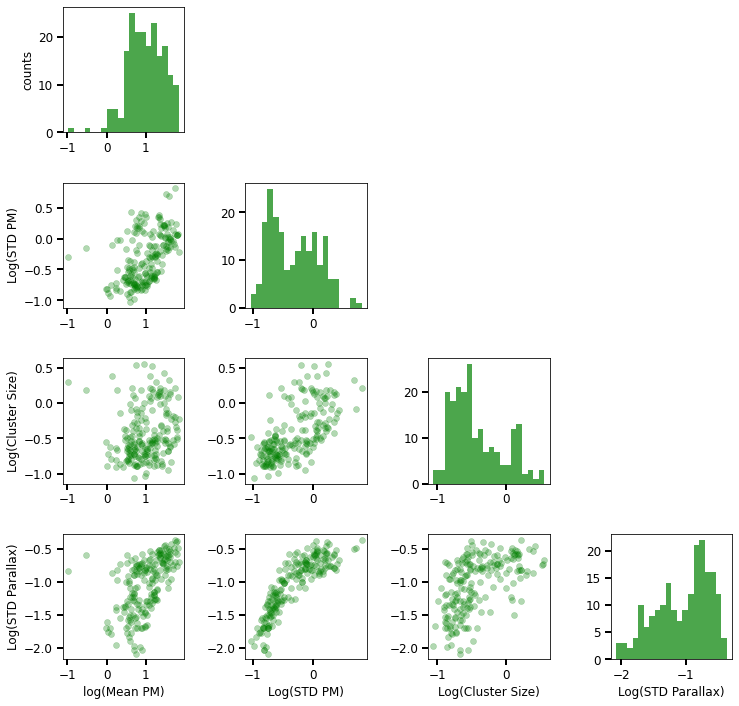

In [69]:
plotting_df = filtered_cluster_stats_corr
labels = ['log(Mean PM)', 'Log(STD PM)', 'Log(Cluster Size)', 'Log(STD Parallax)',]
parameters = ['mean_proper_motion', 'std_proper_motion', 'cluster_size', 'std_parallax',]
corner_plot(labels, plotting_df, parameters)



In [67]:
# correlations
parameters = ['mean_proper_motion', 'std_proper_motion', 'cluster_size', 'std_parallax',]
correlations = pearson_and_spearman_corr(dataframe=filtered_cluster_stats_corr, parameters=parameters, log=False)
correlations

/tmp/ipykernel_9202/106759896.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results_df = pd.concat([


,Comparison,Pearson Coefficient,Pearson P-Value,Spearman Coefficient,Spearman P-Value
0,mean_proper_motion vs std_proper_motion,0.998219,6.196919e-242,0.543851,1.231728e-16
1,mean_proper_motion vs cluster_size,0.997620,1.286047e-229,0.272919,1.002010e-04
2,mean_proper_motion vs std_parallax,0.998545,1.530496e-250,0.621674,1.464188e-22
3,std_proper_motion vs cluster_size,0.999565,6.277217e-302,0.675898,8.827582e-28
4,std_proper_motion vs std_parallax,0.999857,0.000000e+00,0.881928,6.177180e-66
5,cluster_size vs std_parallax,0.999558,2.895029e-301,0.590922,4.992684e-20


### Comments on 4